<a href="https://colab.research.google.com/github/nagamamo/financial_data_science/blob/main/3_single_factor_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3.1　CAPM理論の実装

　本例では、2資産のベータ値を算出することで、2つの銘柄の期待リターンとリスクプレミアムを比較します。例として米ナスダック市場で株式公開される、21世紀を象徴する自動車メーカーのテスラ（TSLA．US）と、20世紀を代表する1908年創業のゼネラル・モータース（GM．US）の、米国自動車メーカーの株価を用います。将来価値が高いと見込まれるEVメーカーと、100年以上の販売実績を持つ老舗ガソリン車メーカーの株主資本コストの違いを比較する事例とも言えるでしょう。ライブラリは統計分析、数値演算用のためのpandas、numpy、データ読み込みを目的とするpandas datareader、標本期間設定のためのdatetime、図表作成のためのmatplotlib.pyplot、回帰分析のためのsklearnの5種類を読み込みます。

In [1]:
#[1]ライブラリの読み込み
import pandas as pd #数値計算用ライブラリの読み込み
import pandas_datareader as data #データ取得用ライブラリ
import datetime
import matplotlib.pyplot as plt #図表作成用ライブラリ
import numpy as np #数値計算用ライブラリの読み込み
from sklearn.linear_model import LinearRegression #回帰分析用ライブラリの読み込み

　続いて、テスラ（TSLA.US）とゼネラル・モータース（GM．US）の株価日次データをpandas_datareaderを用いて取得します。取得する期間は、2012年年初から2022年年末までです。テスラ（TSLA.US）とゼネラル・モータース（GM．US）は、それぞれ取引市場がナスダック市場とニューヨーク市場で異なるため、市場全体の変動を示すマーケット指数には、ナスダック総合指数とダウ平均株価をそれぞれ用います。

In [2]:
#[2]データ取得
tickers=['TSLA.US','^NDQ','GM.US','^DJI'] #証券コードの指定
start=datetime.date(2012,1,1)#標本期間を2019年1月1日から
end=datetime.date(2022,11,30)#2021年12月31日までに指定
df=data.DataReader(tickers,'stooq',start=start,end=end).sort_values(by='Date',ascending=True)

　取得した5種類の株価データから前日比を算出し、変化率の算出の際に発生した欠損値を取り除くソースコードが[3]です。ナスダック総合指数とダウ平均株価の変化率の平均値が、マーケット・ポートフォリオの期待リターンとなります。これらの期待リターンから無リスク資産である米国債の利回りを差し引いた値がマーケット・リスクプレミアムです。このマーケット・リスクプレミアムに、ベータ値を乗じた値に米国債の利回りを加えた値が、投資家がテスラ（TSLA.US）とゼネラル・モータース（GM．US）に求める期待リターン≒株主資本コストとなります。

In [ ]:
#[3]前処理
df = df['Close'].pct_change().dropna()*250 #前日比の算出 #日次の終値のみのデータフレーム
company_list=['Tesla','Nasdaq','GM','DowJones'] #変数名再定義
df.columns = company_list
df.describe() #記述統計量の算出

　次のソースコードでは、テスラ（TSLA.US）とナスダック総合指数の日次株価変動率を単回帰分析することでテスラ社のベータ値を算出しています。二変数の単回帰分析によりベータ値βが直接推計可能となります。この実証モデルがシングル・ファクターモデルと呼ばれるのはこのためです。pandas_datareaderによりデータ取得した場合、その時系列データはpandasデータフレームに納められています。sklearnは、データの入出力にnumpy配列を前提としています。このため、本例では、説明変数と被説明変数を定義する共に、「.values」によりデータをpandasデータフレーム からnumpy配列へ変換します。


In [4]:
#[4]ベータ値の推計：テスラ社
lr1 = LinearRegression()#最小二乗法推計を定義
X = df[['Nasdaq']].values #説明変数の定義と配列変換
Y = df[['Tesla']].values #被説明変数の定義と配列変換    
X1=np.delete(X,0,0)#Numpy配列の欠損値除去
Y1=np.delete(Y,0,0)#Numpy配列の欠損値の除去
lr1.fit(X1, Y1)#理論値の導出 
print('β =  %.4f'% lr1.coef_[0])#小数点以下4桁で係数値表示 
print('intercept = %.4f'% lr1.intercept_)#定数項
print('R_squared = %.4f '% lr1.score(X1,Y1))#決定係数

β =  1.4381
intercept = 0.3614
R_squared = 0.2628 


In [5]:
#[5]ベータ値の推計：GM
lr2 = LinearRegression()
Z = df[['DowJones']].values
W = df[['GM']].values
X2=np.delete(Z,0,0)
Y2=np.delete(W,0,0)
lr2.fit(X2, Y2) 
print('β = %.4f'% lr2.coef_[0]) 
print('intercept = %.4f'% lr2.intercept_)
print('R_squared = %.4f '% lr2.score(X1,Y1))                    

β = 1.2656
intercept = 0.0041
R_squared = 0.2572 


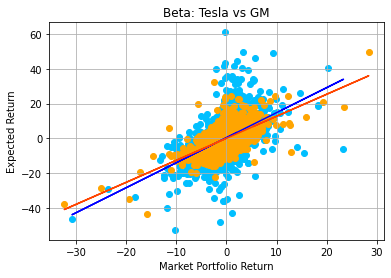

In [6]:
#[6]可視化
plt.scatter(X1,Y1,color ='deepskyblue')#原データのプロット（テスラ、ナスダック）
plt.plot(X1, lr1.predict(X1), color = 'blue')#理論直線のプロット
plt.scatter(X2, Y2, color = 'orange') #原データのプロット（GM、ダウ平均）
plt.plot(X2, lr2.predict(X2), color = 'orangered') #理論直線をプロット
plt.title('Beta: Tesla vs GM') 
plt.xlabel('Market Portfolio Return') #横軸ラベル
plt.ylabel('Expected Return') #縦軸ラベル
plt.grid() #グリッド線表示
plt.show()